<html>
<div style="width:100%">
  <div style="width:90%; float:left; background:white; margin:10px">
    <img style ="width:100%"src ="https://raw.githubusercontent.com/publicunpublic/QCMM_Jupyter/main/full.svg">
    <div style="margin-top:2.5%;position:absolute;background-color:#0e4be5;width:6%;height:0.3%"></div>
  </div>
  </div>


<html>
<center>
<br>
<h1 style="color:#E6610F;"> Optimize TS or Intermediate from QCScan </h1>
<br><br>
</center>

In [2]:
import qcportal as ptl
import numpy as np
import qcelemental as qcel
from pathlib import Path

## Define Variables

In [3]:
client_address = "152.74.10.245:7778"
username = None
password = None
scan_collection_name = "salen_l-lac_i2--i3_02_b3lyp_def2-svp_35_42"
model_chem = "B3LYP-D3BJ/def2-tzvp-Psi4"

In [4]:
client = ptl.FractalClient(address="152.74.10.245:7778", username = username, password = password, verify=False)

##  A)  Check the single point energies from the Scan

In [10]:
import warnings
warnings.filterwarnings("ignore")

ds = client.get_collection("Dataset",scan_collection_name )
ds.get_values(program='psi4')

None
None
None
None
None


,B3LYP/def2-tzvp-Psi4,PBE0/def2-tzvp-Psi4,B3LYP-D3BJ/def2-tzvp-Psi4,PBE0-D3BJ/def2-tzvp-Psi4
3.69,-1111223.044572,-1110046.28489,-1111310.451364,-1110093.378391
3.74,-1111223.146549,-1110046.346097,-1111310.465873,-1110093.378333
3.34,-1111221.612503,-1110045.346793,-1111310.292519,-1110093.181024
3.64,-1111223.057219,-1110046.67941,-1111311.27776,-1110094.249485
3.19,-1111219.392821,-1110043.440054,-1111309.613071,-1110092.188052
3.09,-1111217.800609,-1110042.088742,-1111308.52933,-1110091.140436
3.04,-1111216.933233,-1110041.330339,-1111307.878074,-1110090.514129
3.14,-1111218.638193,-1110042.805009,-1111309.11645,-1110091.70681
3.29,-1111221.083455,-1110044.912434,-1111310.250856,-1110093.028223
3.59,-1111222.986189,-1110046.638251,-1111311.214473,-1110094.222025


##  B)  Plot the Scan trayectory

<IPython.core.display.Javascript object>


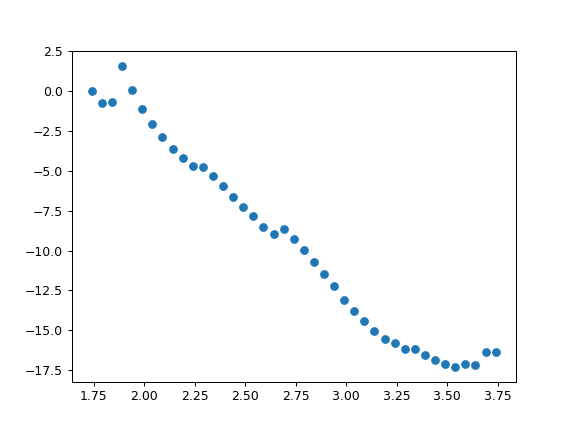

In [11]:
import matplotlib.pyplot as plt
%matplotlib notebook


model_chem = model_chem

scan_df = ds.df
scan_df = scan_df[scan_df[model_chem].notnull()]

init_energy = scan_df[model_chem].sort_index().iloc[0]
scan_df['rel_scan_energy'] = scan_df[model_chem] - init_energy
energy = scan_df['rel_scan_energy']
rx_coord =  [float(x) for x in scan_df.index]

plt.scatter(rx_coord, energy)

<html>
<center>
<br>
<h2> Send TS or Intermediate computation for best candidates </h2>
<br><br>
</center>

## Define variables

In [12]:
#int_candidate_id = 26150 
ts_candidate_id = 26150

entry_name = 'ts2_02'

## A)  Create OptimizationDataset and/or load TS/Intermediate candidate from NEB

#### For TS: 

In [36]:
# Creat or load OptDataset for the ts optimization 
#ds_opt = ptl.collections.OptimizationDataset("salen_d-lac_ts_from_neb", client=client)
ds_opt = client.get_collection("OptimizationDataset", "salen_d-lac_ts_from_scan")
ds_opt.status(collapse=False)

<OptimizationDataset(name=`salen_d-lac_ts_from_neb`, id='93', client='https://152.74.10.245:7778/') >

#### For Int: 

In [36]:
# Creat or load OptDataset for the ts optimization 
#ds_opt = ptl.collections.OptimizationDataset(""salen_d-lac_int_from_neb"", client=client)
ds_opt = client.get_collection("OptimizationDataset", "salen_d-lac_int_from_scan")
ds_opt.status(collapse=False)

<OptimizationDataset(name=`salen_d-lac_ts_from_neb`, id='93', client='https://152.74.10.245:7778/') >

## B) Load candidate molecule from server

In [13]:
mol = client.query_molecules(ts_candidate_id)[0]
mol

NGLWidget()

## C) Add molecule to OptimizationDataset collection

In [78]:
#Add entry to the TS OptimizationDatas

ds_opt.add_entry(entry_name, mol)
ds_opt.save()

'93'

In [ ]:
#Delete Specification

#del ds_opt.data.specs['b3lyp-d3_def2-svp']
#ds_opt.save()

In [76]:
#Delte Entry 

#del ds_opt.data.records['ts2_02']
#ds_opt.save()

'93'

## D)  Add specification for TS/Int optmization with Terachem

This only needs to be done once but doing it again doesn't really hurt

#### For TS: 

In [79]:
kw = ptl.models.KeywordSet(**{"values": {"dftd": "d3", "convthre" : '3.0e-7', "threall" : '1.0e-13', 'dftgrid' : 2, "scf" : "diis+a"}})

kw_id = client.add_keywords([kw])[0]


add_spec = {'name':"b3lyp-d3_def2-svp",
        'description': 'Geometric + TERACHEM/b3lyp-d3/def2-svp.',
        'optimization_spec': {'program': 'geometric', 'keywords': {"transition": "yes", 
                                                                   "converge" :  ["set" , "gau_tight"]}},
        'qc_spec': {'driver': 'gradient',
        'method': "b3lyp",
        'basis': 'def2-svp',
        'keywords': kw_id,
        'program': 'terachem'}}
ds_opt.add_specification(**add_spec,overwrite=True)
ds_opt.save()

'93'

#### For Int: 

In [79]:
kw = ptl.models.KeywordSet(**{"values": {"dftd": "d3", "convthre" : '3.0e-7', "threall" : '1.0e-13', 'dftgrid' : 2, "scf" : "diis+a"}})

kw_id = client.add_keywords([kw])[0]


add_spec = {'name':"b3lyp-d3_def2-svp",
        'description': 'Geometric + TERACHEM/b3lyp-d3/def2-svp.',
        'optimization_spec': {'program': 'geometric', 'keywords': {"transition": "no", 
                                                                   "converge" :  ["set" , "gau_tight"]}},
        'qc_spec': {'driver': 'gradient',
        'method': "b3lyp",
        'basis': 'def2-svp',
        'keywords': kw_id,
        'program': 'terachem'}}
ds_opt.add_specification(**add_spec,overwrite=True)
ds_opt.save()

'93'

## E)  Send computations to the queue

In [80]:
cr = ds_opt.compute(specification = 'b3lyp-d3_def2-svp', tag='tera')#, subset=['HNO2', "HNO", 'HOCN', "N2O"])
cr

1

## F)  Check the status of the TS optimization

In [5]:
ds_opt = client.get_collection("OptimizationDataset", "salen_d-lac_ts_from_neb")
ds_opt.status(collapse = False)

,b3lyp-d3bj_def2-svp,b3lyp-d3_def2-svp
ts1_02,None,COMPLETE
ts1_02_G2,None,COMPLETE
ts1_02_G1,None,COMPLETE
ts1_03,None,COMPLETE
ts1_04,None,COMPLETE
ts2_02,None,COMPLETE
ts1_01,None,COMPLETE


## G)  Check Optimzied Molecules

In [6]:
entry_name = "ts1_02"
model_chem = "b3lyp-d3_def2-svp"

rr = ds_opt.get_record(entry_name, specification = model_chem)
mol = rr.get_final_molecule()
mol

NGLWidget()

## Extras

### Restart jobs

In [ ]:
mol_list = []

spec = 'pbe0-d3_def2-svp'

for i in ds_opt.data.records: 
    #print(i)
    mol_list.append(i)

for i in  mol_list:
    opt_rec = ds_opt.get_record(name=i,specification= spec)
    if (opt_rec.status == 'ERROR'):    
        id_u = opt_rec.id 
        print('yes', i, id_u)
        c = client.modify_tasks("modify", new_tag = 'refinement_tera',base_result = id_u)
        #c = client.modify_tasks("restart",base_result = id_u)
        print(c)